# COMP47250 Team Software Project : University College Dublin
## Exploring Quantum Machine Learning 
Aldridge Abaasa, Neha Mutha, Rahul Matai, Tinoda Garapasi       

Uncomment below if you dont have the libraries installed

In [1]:
#pip install qiskit

In [2]:
#pip install pylatexenc

In [3]:
#pip install azure-quantum

In [4]:
#pip install azure-quantum[qiskit]

In [5]:
#general libraries
import time
import numpy as np
import pandas as pd

#scikit libraries
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

#qiskit libraries
from qiskit import Aer
from qiskit.primitives import Sampler
from qiskit import execute
from qiskit import transpile

#qiskit circuit libraries
from qiskit.circuit.library import ZZFeatureMap,ZFeatureMap,PauliFeatureMap
from qiskit.circuit.library import RealAmplitudes

#qiskit optimizer libraries
from qiskit.algorithms.optimizers import SPSA,COBYLA

#qiskit algorithms
from qiskit_machine_learning.algorithms import VQC,QSVC
from qiskit_machine_learning.kernels import QuantumKernel
from qiskit_machine_learning.neural_networks import EstimatorQNN
from qiskit_machine_learning.algorithms import NeuralNetworkClassifier
from qiskit_machine_learning.exceptions import QiskitMachineLearningError
from qiskit.utils import algorithm_globals

#qiskit azure libraries
from azure.quantum import Workspace
from azure.quantum.qiskit import AzureQuantumProvider


Authentication parameters on Azure.  After the code below is run  a pop up on browser will ask you to verify the qauntum resource.

In [6]:
provider = AzureQuantumProvider (
    resource_id = "/subscriptions/e7eef170-5f0d-42c3-a6c6-9ae33096de85/resourceGroups/AzureQuantum/providers/Microsoft.Quantum/Workspaces/Quantamunia",
    location = "West Europe")

Print all the backends so as to make it easier to choose from the list

In [7]:
print("This workspace's targets:")
for backend in provider.backends():
    print("- " + backend.name())

This workspace's targets:
- ionq.simulator
- ionq.simulator
- ionq.simulator
- ionq.qpu
- ionq.qpu
- ionq.qpu
- ionq.qpu.aria-1
- ionq.qpu.aria-1
- ionq.qpu.aria-1
- quantinuum.hqs-lt-s1-apival
- quantinuum.hqs-lt-s1-apival
- quantinuum.sim.h1-1sc
- quantinuum.sim.h1-1sc
- quantinuum.hqs-lt-s2-apival
- quantinuum.hqs-lt-s2-apival
- quantinuum.sim.h1-2sc
- quantinuum.sim.h1-2sc
- quantinuum.hqs-lt-s1-sim
- quantinuum.hqs-lt-s1-sim
- quantinuum.sim.h1-1e
- quantinuum.sim.h1-1e
- quantinuum.hqs-lt-s2-sim
- quantinuum.hqs-lt-s2-sim
- quantinuum.sim.h1-2e
- quantinuum.sim.h1-2e
- quantinuum.hqs-lt-s1
- quantinuum.hqs-lt-s1
- quantinuum.qpu.h1-1
- quantinuum.qpu.h1-1
- quantinuum.hqs-lt-s2
- quantinuum.hqs-lt-s2
- quantinuum.qpu.h1-2
- quantinuum.qpu.h1-2
- rigetti.sim.qvm
- rigetti.qpu.aspen-m-2
- rigetti.qpu.aspen-m-3
- microsoft.estimator


Specify backend below, the varaiable "backend" will be used later on to deploy to Azure

In [8]:
backend = provider.get_backend("ionq.simulator")
print(backend)

ionq.simulator


In [9]:
iris = datasets.load_iris()
X = iris.data
y = iris.target


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

df = pd.DataFrame(X_test_scaled, columns=iris.feature_names)
df


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,0.529412,0.333333,0.649123,0.458333
1,0.411765,0.750000,0.122807,0.083333
2,1.000000,0.250000,1.035088,0.916667
3,0.500000,0.375000,0.614035,0.583333
4,0.735294,0.333333,0.666667,0.541667
5,0.323529,0.583333,0.087719,0.125000
6,0.382353,0.375000,0.456140,0.500000
7,0.764706,0.458333,0.719298,0.916667
8,0.558824,0.083333,0.614035,0.583333
9,0.441176,0.291667,0.508772,0.458333


In [10]:
N = X.shape[1]
print(N)

4


Declare an array that holds the types of feature maps.  Can always loop through to test for each map.  Feature maps are responsible for encoding classical data into a quantum state

In [11]:
feature_maps = [
    ZFeatureMap(feature_dimension=N, reps=1),    
    PauliFeatureMap(feature_dimension=N, reps=1),
    ZZFeatureMap(feature_dimension=N, reps=1)    
]

Print out the circuit map

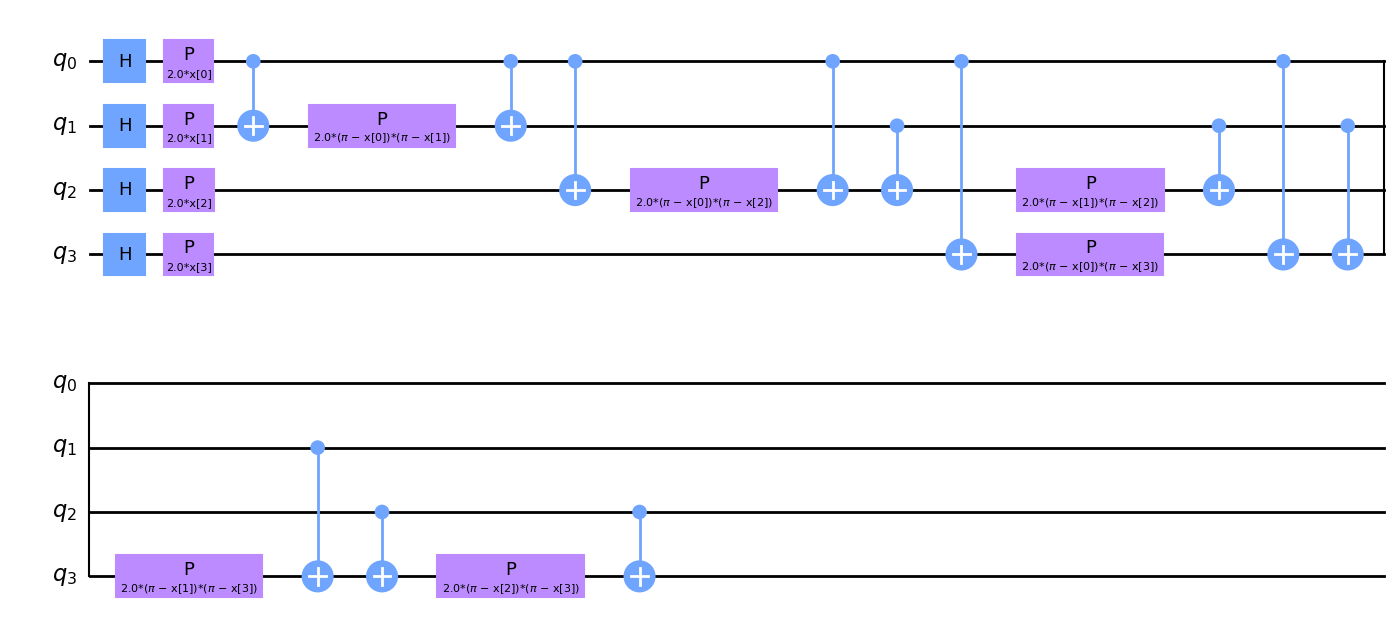

In [12]:
feature_map = feature_maps[2]
feature_map.decompose().draw(output="mpl", fold=20)

create an ansatz. It represents the overall parameterized quantum circuit used to prepare a specific quantum state.

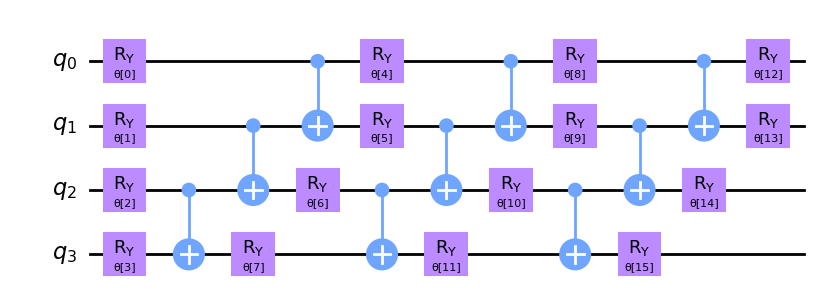

In [14]:
ansatz = RealAmplitudes(num_qubits=N, reps=3)
ansatz.decompose().draw(output="mpl", fold=20)

Initialise optimizer

In [15]:
optimizer = SPSA(maxiter=100)

The parameter "sampler" represents the sampler object that handles the execution of the quantum circuit or the simulation of the quantum model. It is responsible for obtaining measurement outcomes or samples from the quantum circuit.

In [16]:
sampler = Sampler()

In [17]:
from matplotlib import pyplot as plt
from IPython.display import clear_output

objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)


def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

We instantiate VQC and pass the parameters were defining above

In [18]:
vqc = VQC(
    feature_map=feature_map,
    ansatz=ansatz,
    optimizer=optimizer,
    callback=callback_graph,
    sampler=sampler
)

Fit and train classifier.  NB : The training time takes 28 minutes.  For a shorter training time do a PCA or use 50% or 75% of the dataset

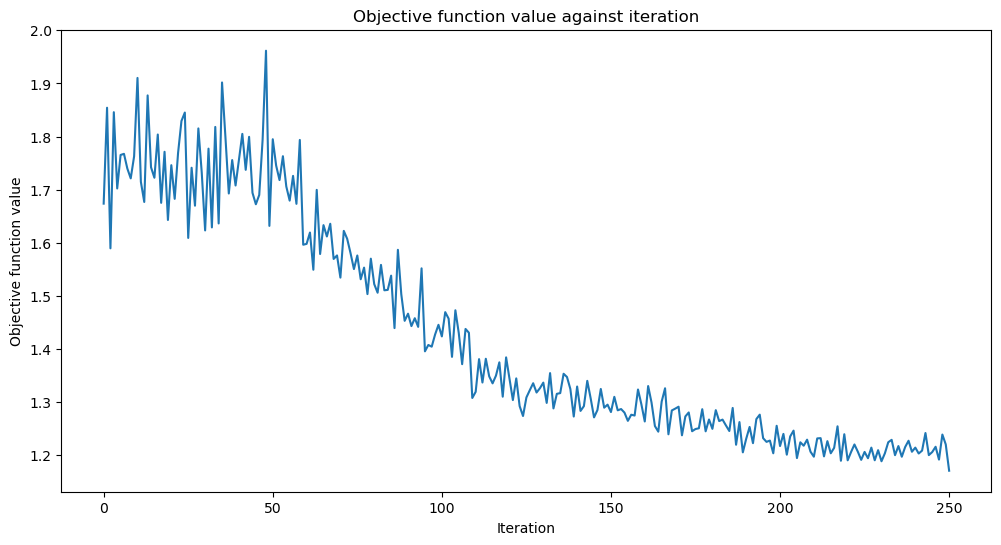

Training time: 1707 seconds


In [19]:
objective_func_vals = []

start = time.time()
vqc.fit(X_train_scaled, y_train)
elapsed = time.time() - start

print(f"Training time: {round(elapsed)} seconds")

In [20]:
train_score = vqc.score(X_train_scaled, y_train)
test_score = vqc.score(X_test_scaled, y_test)

print(f"Quantum VQC on the training dataset: {train_score:.2f}")
print(f"Quantum VQC on the test dataset:     {test_score:.2f}")

Quantum VQC on the training dataset: 0.77
Quantum VQC on the test dataset:     0.70


In [21]:
y_pred = vqc.predict(X_test_scaled)
print("Predicted labels:", y_pred)

Predicted labels: [1 0 2 1 0 0 1 2 0 1 2 1 1 1 0 2 2 1 1 2 0 2 0 2 0 2 2 2 1 1]


In [22]:
# Compute accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.7


In [23]:
# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[ 5  5  0]
 [ 2  6  1]
 [ 1  0 10]]


 Generates random parameter values for the variational circuit

In [24]:
import random
from qiskit.circuit import Parameter


In [25]:
var_circuit = vqc.circuit
params = var_circuit.parameters
print(params)

ParameterView([ParameterVectorElement(x[0]), ParameterVectorElement(x[1]), ParameterVectorElement(x[2]), ParameterVectorElement(x[3]), ParameterVectorElement(θ[0]), ParameterVectorElement(θ[1]), ParameterVectorElement(θ[2]), ParameterVectorElement(θ[3]), ParameterVectorElement(θ[4]), ParameterVectorElement(θ[5]), ParameterVectorElement(θ[6]), ParameterVectorElement(θ[7]), ParameterVectorElement(θ[8]), ParameterVectorElement(θ[9]), ParameterVectorElement(θ[10]), ParameterVectorElement(θ[11]), ParameterVectorElement(θ[12]), ParameterVectorElement(θ[13]), ParameterVectorElement(θ[14]), ParameterVectorElement(θ[15])])


In [26]:
random_values = [random.uniform(0, 2 * np.pi) for _ in range(len(params))]

Binds the random parameter values to the variational circuit before executing so as to prevent the type error:  "TypeError: ParameterExpression with unbound parameters."

In [27]:
bound_circuit = var_circuit.bind_parameters(dict(zip(params, random_values)))


Send job to execute to Azure.

In [28]:
job = execute(bound_circuit, backend=backend)
result = job.result()

........

Results from Azure output as a histogram.  From this histogram we can then convert it to extract metric values such as F1 score, confusin matrix etc.

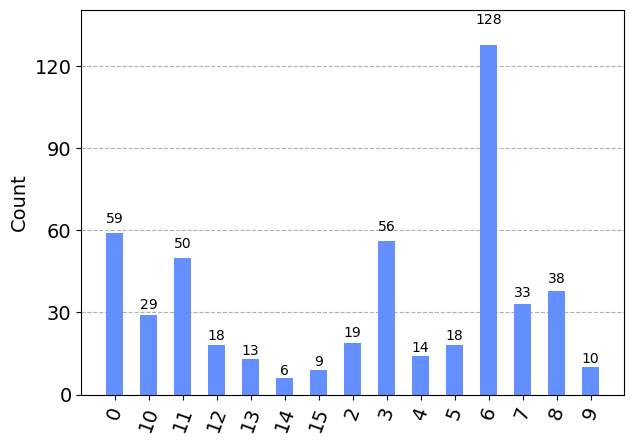

In [29]:
from qiskit.visualization import plot_histogram
counts = result.get_counts()
plot_histogram(counts)